In [4]:
import pandas as pd 
from collections import Counter

data = pd.read_csv('shorts2.csv',sep=",")["Content"]

with open("stopwords","r",encoding="utf-8") as f :
    stopwords = f.readlines()

stopwords = [s.replace("\n","") for s in stopwords ]

def remove_stop(strg):
    strg_split= strg.split(" ")
    strg_split = [a for a in strg_split if a not in stopwords]
    strg = " ".join(strg_split)
    return strg

def preprocess(df):
    df = df.apply(lambda x: x.lower())
    Counter(" ".join(df).split()).most_common(100)

    df = df.apply(remove_stop)
    return df

data = preprocess(data)
print(data)
#data = pd.read_csv("data/csv_data/shorts.csv",sep =",")
data = data.fillna('')
data = list(data)

Counter(" ".join(data).split()).most_common(100)


0        biskupi polsce przyznają prawo moralizowania,...
1        rocznie polsce raka piersi umiera blisko 5 ty...
2                                            faithfully r
3        trwa wojna ukrainie. ukrainki, ukraińcy bohat...
4        ministrze czarnyku dziwnych wydatkach. wiecie...
                              ...                        
4159     pojawia pytanie, lewaki wezmą pieniądze? nasz...
4160     wprowadzenie podatku cukrowego naprawdę dobry...
4161     poseł magdalena biejat, klub parlamentarny le...
4162    [" różnice językowe konfederacją lewicą. in le...
4163     możecie przestać pierdzielić głupoty, pis lew...
Name: Content, Length: 4164, dtype: object


[('to,', 938),
 ('prostu', 665),
 ('mamy', 561),
 ('tak,', 550),
 ('proszę', 516),
 ('tym,', 494),
 ('tego,', 484),
 ('się,', 474),
 ('panie', 462),
 ('naprawdę', 455),
 ('polsce', 428),
 ('prawo', 418),
 ('prawa', 416),
 ('nie,', 383),
 ('polska', 355),
 ('nie.', 341),
 ('przykład', 340),
 ('oczywiście', 331),
 ('chyba', 317),
 ('ludzie', 299),
 ('ogóle', 291),
 ('tak.', 284),
 ('rząd', 281),
 ('mieć', 276),
 ('myślę,', 274),
 ('państwo', 267),
 ('będziemy', 265),
 ('złotych', 254),
 ('pieniądze', 252),
 ('wiem,', 251),
 ('jakieś', 243),
 ('chodzi', 240),
 ('polski', 237),
 ('minister', 234),
 ('takich', 229),
 ('tysięcy', 228),
 ('chce', 224),
 ('jesteśmy', 222),
 ('the', 219),
 ('pis', 216),
 ('czas', 212),
 ('trochę', 211),
 ('ludzi', 211),
 ('mówi', 204),
 ('pewno', 202),
 ('państwo,', 201),
 ('państwa', 200),
 ('powiedzieć,', 195),
 ('dzieci', 194),
 ('tą', 194),
 ('miał', 190),
 ('raz', 188),
 ('dlatego,', 186),
 ('niestety', 185),
 ('unii', 183),
 ('chcą', 182),
 ('dzień', 181)

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(data, show_progress_bar=True)


/home/kprm-linux/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches:   0%|          | 0/131 [00:00<?, ?it/s]

In [ ]:
import numpy as np

import umap.umap_ as umap
umap_embeddings =umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)



In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)



NameError: name 'umap_embeddings' is not defined

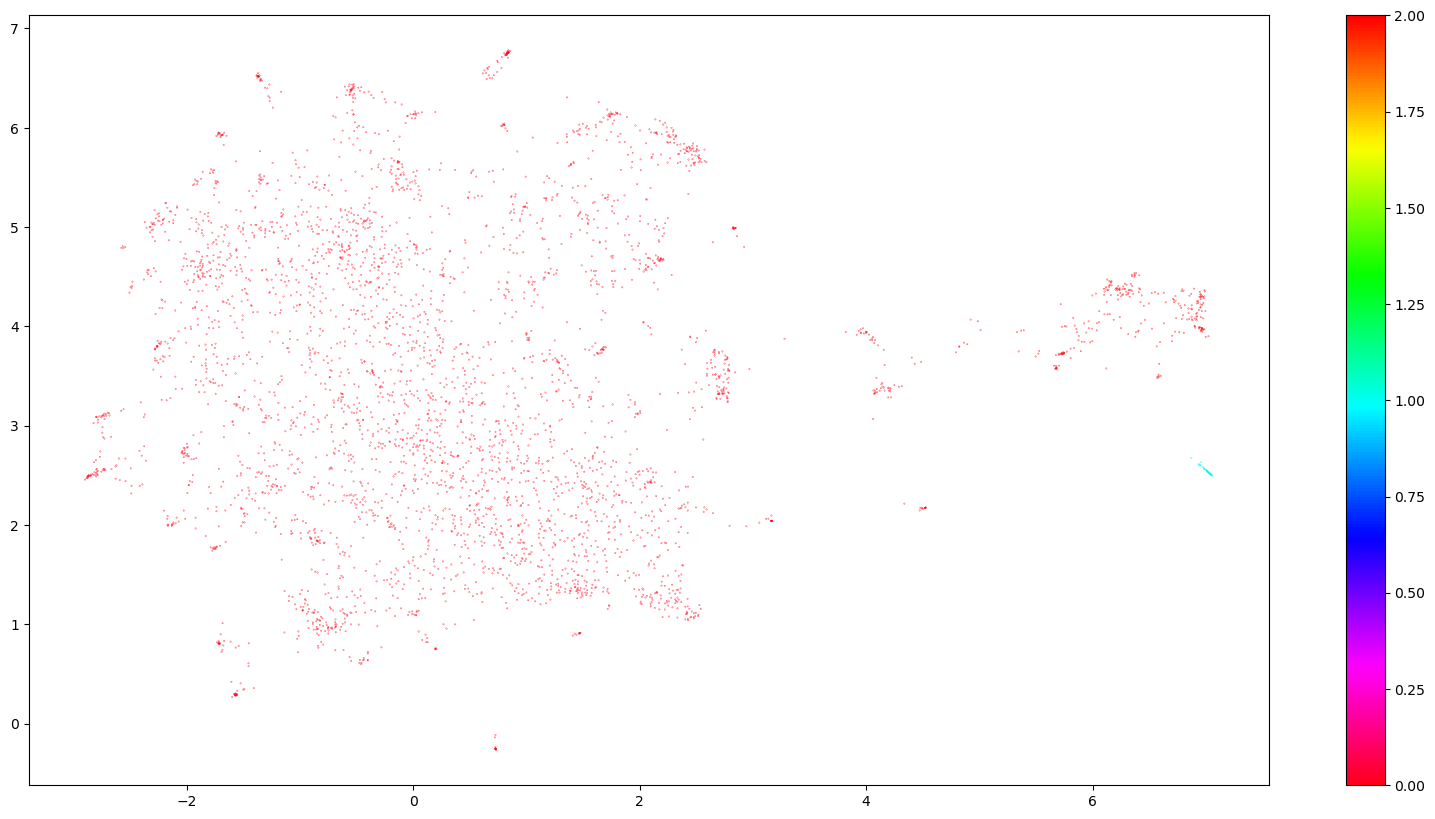

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
plt.savefig("mapka.png")



In [ ]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
print(docs_df)

                                                    Doc  Topic  Doc_ID
0      biskupi polsce przyznają prawo moralizowania,...      0       0
1      rocznie polsce raka piersi umiera blisko 5 ty...      0       1
2                                          faithfully r      2       2
3      trwa wojna ukrainie. ukrainki, ukraińcy bohat...      0       3
4      ministrze czarnyku dziwnych wydatkach. wiecie...      0       4
...                                                 ...    ...     ...
4159   pojawia pytanie, lewaki wezmą pieniądze? nasz...      0    4159
4160   wprowadzenie podatku cukrowego naprawdę dobry...      0    4160
4161   poseł magdalena biejat, klub parlamentarny le...      0    4161
4162  [" różnice językowe konfederacją lewicą. in le...      0    4162
4163   możecie przestać pierdzielić głupoty, pis lew...      0    4163

[4164 rows x 3 columns]


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))



In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

NameError: name 'tf_idf' is not defined

In [ ]:
top_n_words[2][:30]

NameError: name 'top_n_words' is not defined